## Importing dataset

In [ ]:
from google.colab import drive
import os
# drive.mount('/content/drive')
# DATA_PATH = "/content/drive/MyDrive/university/machine_learning/data"


In [ ]:
# =============================== download dataset =========================
import gdown
import zipfile

def gdrive_download(file_id: str,out_dir: str):
  """
    download [file_id] expected to be a zip
    and extract it to folder [out_dir]
  """
  url = "https://drive.google.com/uc?id=" + file_id
  output = 'dataset.zip'
  gdown.download(url, output, quiet=False,fuzzy=True)

  # unzip the downloaded dataset
  with zipfile.ZipFile(output, 'r') as zip_ref:
      zip_ref.extractall(out_dir)

# the dataset
# go to another directory called data because
# it is in "dataset/data/"
dataset_dir = "dataset"
gdrive_download(file_id="1xMG984Rvne3bqmFJjhcKoEMrbFxv3NPn", out_dir = dataset_dir)
DATA_PATH = os.path.join(dataset_dir,"data")






Downloading...
From: https://drive.google.com/uc?id=1xMG984Rvne3bqmFJjhcKoEMrbFxv3NPn
To: /content/dataset.zip
100%|██████████| 4.50M/4.50M [00:00<00:00, 28.7MB/s]


In [ ]:
!ls /content/drive/MyDrive/university/machine_learning/data

ls: cannot access '/content/drive/MyDrive/university/machine_learning/data': No such file or directory


In [ ]:
import numpy as np
import cv2



In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt

from torchvision.io import read_image

In [ ]:
import math
from sklearn import preprocessing
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class ChessCustomDataset(Dataset):
  TRAIN_TEST_SPLIT_RATIO = 0.9

#  IMAGE_WIDTH = 90
#  IMAGE_HEIGHT = 90


  def load_data(self):
    # ===================== load data =============================
    # load the data
    # get all folder in that data, which names are the label
    DATA_INFO = next(os.walk(DATA_PATH))
    DATA_LABEL = DATA_INFO[1]
    # array of [label,image array]
    IMAGE_DATA = []
    for piece_class in DATA_LABEL:
      # load all files in that directory
      current_dir = os.path.join(DATA_PATH, piece_class)
      for f in os.listdir(current_dir):
        # get the full path
        current_file = os.path.join(current_dir,f)
        if not os.path.isfile(current_file):
          continue
        # read image as an numpy array of rgb
        # https://stackoverflow.com/questions/7762948/how-to-convert-an-rgb-image-to-numpy-array
        img = cv2.imread(current_file, cv2.IMREAD_GRAYSCALE)

        #img = read_image(current_file, mode = ImageReadMode.GRAY)

        # add
        IMAGE_DATA.append([img, piece_class])

    print(f"one image {IMAGE_DATA[0][0]}")
    return IMAGE_DATA
  def get_image_min_dimension(self, image_data):
    min_area = math.inf
    min_dimension = (0,0)
    for i in range(0,len(image_data)):
      img = image_data[i][0]
        # assign minimal dimension
        # we can get the height and width at index of 0 and 1
        # because image is stored as 2d array of rgb
      img_area = img.shape[0] * img.shape[1]
      if img_area < min_area:
        min_area = img_area
        min_dimension = (img.shape[0], img.shape[1])

    return min_dimension


  def resize_img(self, dsize=(0,0)):

    # need to resize the image to the sae height and weight
    # before feeding to nn

    img_resizer = Resize(dsize)
    for data in self.IMAGE_DATA:
      data[0] = cv2.resize(data[0],dsize=(dsize[0],dsize[1]),interpolation=cv2.INTER_CUBIC)
      #data[0] = img_resizer(data[0])
    print("resized image to ")
    print(dsize)


  def one_hot_label_to_str():
    pass

  def __init__(self,transform=None, target_transform=None, is_train_data:bool = None):
    self.transform= transform
    self.target_transform = target_transform

    self.IMAGE_DATA = self.load_data()
    # retrieve string label as array
    labels_str = []
    for data in self.IMAGE_DATA:
      label_str = data[1]
      if label_str not in labels_str:
        labels_str.append(label_str)
    # ======================
    # convert list of string to tensor of value
    # so the label will become numerical
    # https://stackoverflow.com/questions/44617871/how-to-convert-a-list-of-strings-into-a-tensor-in-pytorch
    le = preprocessing.LabelEncoder()
    labels_numeric = le.fit_transform(labels_str)
    # create label mapping between
    # the index (key) and string value (value)
    # https://stackoverflow.com/questions/209840/how-can-i-make-a-dictionary-dict-from-separate-lists-of-keys-and-values
    self.LABEL_NUMERIC_TO_LABEL_STR_MAP = dict(zip(labels_numeric, labels_str))
    self.LABEL_STR_TO_LABEL_NUMERIC_MAP = {v: k for k, v in self.LABEL_NUMERIC_TO_LABEL_STR_MAP.items()}

  def get_str_label(self, label_idx) -> str:
    """
    label index is tensor of shape(1)
    """
    label_idx = label_idx.item()
    # print(f"getting string label {label_idx}")
    # print(f"the map {self.LABEL_NUMERIC_TO_LABEL_STR_MAP}")
    return self.LABEL_NUMERIC_TO_LABEL_STR_MAP[label_idx]





  def __len__(self):
    return len(self.IMAGE_DATA)

  def __getitem__(self, idx):
    image = self.IMAGE_DATA[idx][0]
    label = self.IMAGE_DATA[idx][1]
    # use numerical label whenever possible
    label_idx = self.LABEL_STR_TO_LABEL_NUMERIC_MAP[label]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label_idx = self.target_transform(label_idx)
    return image,label_idx



In [ ]:
# ============================================
# determine the image dimension for all image
# as the minimum  dimension (LxH) of all image
# where L == H
dataset = ChessCustomDataset(
    transform = ToTensor()
)
img_min_dimension = dataset.get_image_min_dimension(dataset.IMAGE_DATA)

# create the image dimension to the same minimal length or width
IMAGE_DIMENSION = (min(img_min_dimension), min(img_min_dimension))
dataset.resize_img(dsize=IMAGE_DIMENSION)

one image [[168 171 172 ... 170 168 131]
 [167 171 172 ... 167 168 132]
 [170 171 170 ... 168 167 137]
 ...
 [143 143 145 ... 147 140 133]
 [106 105 106 ...  94  98 109]
 [103  99 100 ...  79  86 107]]
resized image to 
(46, 46)


In [ ]:

print("data count " + str((len(dataset))))
img,label = dataset.__getitem__(0)
print(label)
print(img.shape)

data count 693
0
torch.Size([1, 46, 46])


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))


Feature batch shape: torch.Size([64, 1, 46, 46])
Labels batch shape: 64
torch.Size([46, 46])


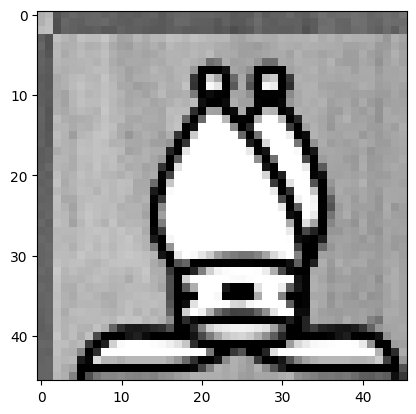

Label: bishop


In [ ]:
# look at a random image and its label
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
# we squueze the image
# to remove the "outer array"
# because our image format is in (1,H,W)
# basically the shape is [[1,H,W]]
# but we cannot show the image with 2d array
# therefore we need to convert it to 1d
img = train_features[1].squeeze()
label = dataset.get_str_label(train_labels[1])
print(img.shape)
# because pytorch's tensor when representing image
# are rgb channel first like (3,H,L)
# we need to reorder it, because matplotlib expects to be
# channel last like (H,L,3)
# https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
x = train_features[0]
print(x)

tensor([[[0.6588, 0.6745, 0.6784,  ..., 0.6784, 0.6706, 0.5451],
         [0.6627, 0.6706, 0.6745,  ..., 0.6549, 0.6627, 0.5569],
         [0.6667, 0.6706, 0.6667,  ..., 0.6549, 0.6588, 0.5490],
         ...,
         [0.6667, 0.6588, 0.6588,  ..., 0.6941, 0.6824, 0.5725],
         [0.5059, 0.5137, 0.5059,  ..., 0.5059, 0.5020, 0.4902],
         [0.4000, 0.3922, 0.3961,  ..., 0.3333, 0.3176, 0.4039]]])


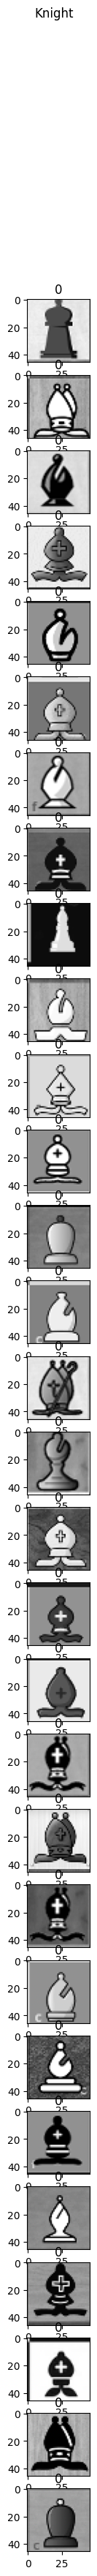

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=30, figsize=(5,40))
fig.suptitle('Knight')
for i in range(0,30):
  img, label = dataset.__getitem__(i)

  img = img.squeeze()

  ax[i].set_title(label)
  ax[i].imshow(img, cmap = 'gray')

# Creation between test and train data


In [ ]:
# https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

from torch.utils.data import random_split
TRAIN_TEST_SPLIT_RATIO = 0.8
print("original data length %d" % (len(dataset)))
train_size = int(TRAIN_TEST_SPLIT_RATIO * len(dataset))
test_size = len(dataset) - train_size
training_data, test_data = random_split(dataset,[train_size,test_size])

original data length 693


In [ ]:
print("training data count: %d" % len(training_data))
print("test data count: %d" % len(test_data))

training data count: 554
test data count: 139


In [ ]:
train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

# building model


In [ ]:
from torch import nn

LABELS_LENGTH = len(dataset.LABEL_NUMERIC_TO_LABEL_STR_MAP)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # TODO: because our image is rgb, we need to transform
            # it to grayscale
            nn.Linear(IMAGE_DIMENSION[0]*IMAGE_DIMENSION[1], 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, LABELS_LENGTH),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)
print(f"model arch:\n {model}")

model arch:
 NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2116, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [ ]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print("Model Summary:")
print("---------------------------------")
print("{:<30} {:<25} {:<15}".format("Layer", "Output Shape", "Param #"))
print("---------------------------------")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        num_params = param.numel()
        total_params += num_params
        print("{:<30} {:<25} {:<15}".format(name, str(list(param.size())), num_params))
print("---------------------------------")
print("Total Trainable Parameters: ", total_params)

Model Summary:
---------------------------------
Layer                          Output Shape              Param #        
---------------------------------
linear_relu_stack.0.weight     [512, 2116]               1083392        
linear_relu_stack.0.bias       [512]                     512            
linear_relu_stack.2.weight     [512, 512]                262144         
linear_relu_stack.2.bias       [512]                     512            
linear_relu_stack.4.weight     [6, 512]                  3072           
linear_relu_stack.4.bias       [6]                       6              
---------------------------------
Total Trainable Parameters:  1349638


In [ ]:
from torchsummary import summary

In [ ]:
summary(model, (1,46,46))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2116]               0
            Linear-2                  [-1, 512]       1,083,904
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                    [-1, 6]           3,078
Total params: 1,349,638
Trainable params: 1,349,638
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 5.15
Estimated Total Size (MB): 5.19
----------------------------------------------------------------


In [ ]:
model.summary()

AttributeError: ignored

# Training Model

In [ ]:
learning_rate = 1e-1
batch_size = 32
epochs = 100

# example of simple loss function is nn.MSELoss
# but for image, this maybe okay
loss_fn = nn.CrossEntropyLoss()


In [ ]:
# optimizer
# the process on how to adjust the model params
# here we gonna use stochastic gradient descent
print(f"model params {model.parameters()}")
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# in pytorch, each epoch have three mainsteps
# optimizer.zero_grad() reset the gradients of model parameters
# because it by default adds up (probably means after first iteration
# is finished, the gradient from previous will be used to the next one)
# which is not what we want

# backpropogate the prediction loss to all layer
# loss.backward()

# once the gradient is retrieved, we call opimizer.step()
# to adjust parameters by gradients collected in backward phase

model params <generator object Module.parameters at 0x7f085e342b20>


In [ ]:
nn_test_accuracy_list = []
nn_train_accuracy_list = []

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch_idx, (X,y) in enumerate(dataloader):
    # compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred,y)
    #  back propogate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print each loss

    if batch_idx % 5 == 0:
        # loss value is gonna be tensor
        # we need to call item to convert tensor of length one
        # to numeric
        loss, current = loss.item(), (batch_idx + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    pass
  pass

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = correct * 100
    nn_test_accuracy_list.append(accuracy)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")




In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Streaming output truncated to the last 5000 lines.

Epoch 4287
-------------------------------
loss: 0.030799  [   64/  554]
loss: 0.041249  [  384/  554]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.922440 

Epoch 4288
-------------------------------
loss: 0.063230  [   64/  554]
loss: 0.042179  [  384/  554]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.834764 

Epoch 4289
-------------------------------
loss: 0.041498  [   64/  554]
loss: 0.041658  [  384/  554]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.923816 

Epoch 4290
-------------------------------
loss: 0.049417  [   64/  554]
loss: 0.065960  [  384/  554]
Test Error: 
 Accuracy: 71.2%, Avg loss: 0.846599 

Epoch 4291
-------------------------------
loss: 0.027095  [   64/  554]
loss: 0.073829  [  384/  554]
Test Error: 
 Accuracy: 71.9%, Avg loss: 1.089501 

Epoch 4292
-------------------------------
loss: 0.063577  [   64/  554]
loss: 0.063178  [  384/  554]
Test Error: 
 Accuracy: 71.9%, Avg loss: 1.047044 

Epoch 4293
-------

In [ ]:
torch.save(model, 'model.pth')

# Transfer learning

In [ ]:
import PIL as image_lib

import tensorflow as tflow

from tensorflow.keras.layers import Flatten

from keras.layers.core import Dense

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

In [ ]:
img_height,img_width=180,180

batch_size=16

train_ds = tflow.keras.preprocessing.image_dataset_from_directory(

  DATA_PATH,

  validation_split=0.2,

  subset="training",

  seed=123,

label_mode='categorical',

  image_size=(img_height, img_width),

  batch_size=batch_size)

Found 693 files belonging to 7 classes.
Using 555 files for training.


In [ ]:
validation_ds = tflow.keras.preprocessing.image_dataset_from_directory(

  DATA_PATH,

  validation_split=0.2,

  subset="validation",

  seed=123,

label_mode='categorical',

  image_size=(img_height, img_width),

  batch_size=batch_size)

Found 693 files belonging to 7 classes.
Using 138 files for validation.


In [ ]:
import matplotlib.pyplot as plotter_lib

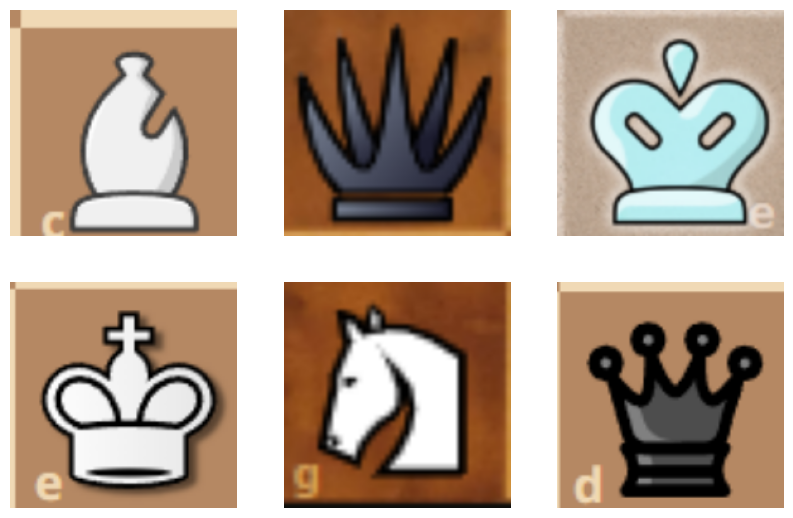

In [ ]:
plotter_lib.figure(figsize=(10, 10))

epochs=10

for images, labels in train_ds.take(1):

  for var in range(6):

    ax = plotter_lib.subplot(3, 3, var + 1)

    plotter_lib.imshow(images[var].numpy().astype("uint8"))

    plotter_lib.axis("off")

In [ ]:
demo_resnet_model = Sequential()

pretrained_model_for_demo= tflow.keras.applications.ResNet50(include_top=False,

                   input_shape=(180,180,3),

                   pooling='avg',classes=6,

                   weights='imagenet')

for each_layer in pretrained_model_for_demo.layers:

        each_layer.trainable=False

demo_resnet_model.add(pretrained_model_for_demo)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
demo_resnet_model.add(Flatten())

demo_resnet_model.add(Dense(512, activation='relu'))

demo_resnet_model.add(Dense(7, activation='softmax'))
demo_resnet_model.compile(optimizer = tflow.keras.optimizers.SGD(learning_rate=0.1), loss = 'binary_crossentropy', metrics = ['acc'])
demo_resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 1,052,679
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
history = demo_resnet_model.fit(train_ds, epochs=100, validation_data = validation_ds)

Epoch 1/100
35/35 [==============================] - 10s 109ms/step - loss: 0.2825 - acc: 0.6018 - val_loss: 0.2184 - val_acc: 0.7101
Epoch 2/100
35/35 [==============================] - 2s 50ms/step - loss: 0.1448 - acc: 0.8595 - val_loss: 0.1476 - val_acc: 0.8551
Epoch 3/100
35/35 [==============================] - 2s 60ms/step - loss: 0.1001 - acc: 0.9189 - val_loss: 0.1219 - val_acc: 0.8551
Epoch 4/100
35/35 [==============================] - 2s 51ms/step - loss: 0.0804 - acc: 0.9243 - val_loss: 0.1065 - val_acc: 0.8696
Epoch 5/100
35/35 [==============================] - 2s 51ms/step - loss: 0.0630 - acc: 0.9622 - val_loss: 0.0918 - val_acc: 0.8913
Epoch 6/100
35/35 [==============================] - 2s 51ms/step - loss: 0.0539 - acc: 0.9676 - val_loss: 0.0937 - val_acc: 0.8768
Epoch 7/100
35/35 [==============================] - 2s 51ms/step - loss: 0.0456 - acc: 0.9748 - val_loss: 0.0713 - val_acc: 0.9203
Epoch 8/100
35/35 [==============================] - 2s 51ms/step - loss: 

## Graph TL

In [ ]:
acc_list = [acc * 100 for acc in history.history['acc']]

In [ ]:
val_acc_list = [val_acc * 100 for val_acc in history.history['val_acc']]

In [ ]:
val_acc_list

[72.46376872062683,
 82.6086938381195,
 85.50724387168884,
 88.40579986572266,
 89.85507488250732,
 89.85507488250732,
 92.75362491607666,
 91.30434989929199,
 94.20289993286133,
 92.02898740768433,
 92.02898740768433,
 92.75362491607666,
 93.478262424469,
 92.75362491607666,
 94.20289993286133,
 93.478262424469,
 94.92753744125366,
 94.20289993286133,
 94.20289993286133,
 93.478262424469,
 93.478262424469,
 93.478262424469,
 92.75362491607666,
 94.20289993286133,
 95.652174949646,
 93.478262424469,
 94.20289993286133,
 94.92753744125366,
 94.20289993286133,
 94.92753744125366,
 94.20289993286133,
 94.20289993286133,
 93.478262424469,
 94.92753744125366,
 94.92753744125366,
 94.92753744125366,
 95.652174949646,
 94.20289993286133,
 94.20289993286133,
 95.652174949646,
 94.92753744125366,
 95.652174949646,
 95.652174949646,
 94.92753744125366,
 94.92753744125366,
 95.652174949646,
 94.92753744125366,
 94.92753744125366,
 94.92753744125366,
 94.92753744125366,
 94.20289993286133,
 94.927

In [ ]:
acc_list

[60.00000238418579,
 85.58558821678162,
 90.63063263893127,
 93.1531548500061,
 95.85585594177246,
 96.57657742500305,
 97.47747778892517,
 98.01802039146423,
 98.73873591423035,
 98.91892075538635,
 98.91892075538635,
 99.27927851676941,
 99.09909963607788,
 99.45945739746094,
 99.63964223861694,
 99.45945739746094,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.45945739746094,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.81982111930847,
 99.81982111930847,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 99.63964223861694,
 

# conv neural network


In [ ]:
LABELS_LENGTH

6

In [ ]:
from torch.nn.modules import Softmax
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # image channel is only one because
        # our image is grayscale
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 6,
                               kernel_size = 5,
                               )
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, LABELS_LENGTH)

    def forward(self, x):
        # print(f"forward: before {x.shape}")
        x = self.pool(F.relu(self.conv1(x)))
        # print(f"forward: 1 {x.shape}")
        x = self.pool(F.relu(self.conv2(x)))
        # print(f"forward: 2 {x.shape}")
        # flatten all dimensions except batch
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


convNet = ConvNet()


#https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
# See point 7 "Model 2: Building a Convolutional Neural Network (CNN)"
#https://poloclub.github.io/cnn-explainer/
# scroll down to "Understanding Hyperparameters" for visualization of parameters effects
from torch import nn

class chessRecognizerv2CNN(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential( #first convolutional block
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units, #num of units for capturing different patterns
                  kernel_size = 3, #for blurring ,scanning with matrix of 3x3, takes average value from 3x3 to create new value for middle pixel
                  stride = 1, #scan every pixel, -> output shape from this layer -> resolution: (n/stride x n/stride)
                  padding = 1), # res 46 x 46 -> 47 x 47
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2) #takes max value out of (kernel_size x kernel size) matrix, ditch other values, keep max.
    )# img resolution from max pool = (n/kernel_size x n/kernel_size)
    self.conv_block_2 = nn.Sequential( # second conv block, does the exact same as the first
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(), #turns shape to (n x m)
        nn.Linear(in_features=hidden_units*11*11, # matching matrix shape(inner dimension) to (m x k) -> (n x m) w (m x k)
                  out_features = LABELS_LENGTH), #num of classes
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f" Output of conv block 1 : {x.shape}")
    x = self.conv_block_2(x)
    # print(f" Output of conv block 2 : {x.shape}")
    x = self.classifier(x)
    # print(f" Output of classifier : {x.shape}")
    # printing to track the shape equation needed for line 39 (hidden_units*11*11)
    return x

## Instance of model


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_2 = chessRecognizerv2CNN(input_shape = 1, #  1 = grey scale, 3 = rgb
                              hidden_units = 128,
                              output_shape = 6).to(device) #num of classes

In [ ]:
summary(model_2, (1,46,46))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 46, 46]           1,280
              ReLU-2          [-1, 128, 46, 46]               0
            Conv2d-3          [-1, 128, 46, 46]         147,584
              ReLU-4          [-1, 128, 46, 46]               0
         MaxPool2d-5          [-1, 128, 23, 23]               0
            Conv2d-6          [-1, 128, 23, 23]         147,584
              ReLU-7          [-1, 128, 23, 23]               0
            Conv2d-8          [-1, 128, 23, 23]         147,584
              ReLU-9          [-1, 128, 23, 23]               0
        MaxPool2d-10          [-1, 128, 11, 11]               0
          Flatten-11                [-1, 15488]               0
           Linear-12                    [-1, 6]          92,934
Total params: 536,966
Trainable params: 536,966
Non-trainable params: 0
-------------------------------

## Setup loss function, acc function, optimizer

In [ ]:
#https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
# see point 3.1
import requests
from pathlib import Path

#Download helper func from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download..")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss() # cross entropy for multi class loss
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [ ]:
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

## Training and Testing

In [ ]:
#https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
# See point 6.2 "Functionizing training and test loops"
def training_step(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  accuracy_fn,
                  device: torch.device = device):
  ### Training
  trainLoss, trainAcc = 0, 0

  model.train()
  # Loop through training batches
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    #Forward Pass
    y_pred = model(X)

    # Calc loss per batch
    loss = loss_fn(y_pred, y)
    trainLoss += loss # accumulate train loss
    trainAcc += accuracy_fn(y_true = y,
                            y_pred = y_pred.argmax(dim=1))

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss Backward
    loss.backward()

    optimizer.step()

    # Print per 400 batches
    # if batch % 400 == 0:
    #   print(f"Model have been through {batch * len(X)}/{len(trainDataloader.dataset)} samples.")
  # Divide total train loss by length of train Dataloader
  trainLoss /= len(data_loader)  #avg
  trainAcc /= len(data_loader)

  print(f"Train loss: {trainLoss:.5f} | Train acc: {trainAcc:.2f}%")

  return trainAcc, trainLoss

#https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
# See point 6.2 "Functionizing training and test loops"
def testing_step(model: torch.nn.Module,
                 data_loader: torch.utils.data.DataLoader,
                 loss_fn: torch.nn.Module,
                 accuracy_fn,
                 device: torch.device = device):
  ### Testing
  testLoss, testAcc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      # 1 Forward pass
      testPred = model(X)

      # 2 Calc loss
      testLoss += loss_fn(testPred, y)

      # 3 Calc acc           actual label      (label)  index of predicted y
      testAcc += accuracy_fn(y_true = y,
                             y_pred = testPred.argmax(dim=1))

    # Calc test loss avg per batch
    testLoss /= len(data_loader)

    # Calc acc avg per batch
    testAcc /= len(data_loader)

  #Printing
  print(f"\nTest loss : {testLoss:.5f} | Test acc: {testAcc:.2f}%\n")

  return testAcc, testLoss

## Print train time func

In [ ]:
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
# see point 3.2 "Creating a function to time our experiments"
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device : torch.device = None):
  """Prints end - start"""
  total_time = end - start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

##CNN Train

In [ ]:
#https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
# see point 7.4 "Training and testing model_2 using our training and test functions"
from timeit import default_timer as timer
from tqdm.auto import tqdm # for progress bar
# Set seed start timer
train_time_start_on_gpu = timer()

# Set epoch number
epochs = 100
CNNtrainAccList = []
CNNtestAccList = []
CNNtrainLossList = []
CNNtestLossList = []
# Create train n test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  ### Training
  accuracy, loss = training_step(model = model_2,
                data_loader = train_dataloader,
                loss_fn = loss_fn,
                optimizer = optimizer,
                accuracy_fn = accuracy_fn,
                device = device)
  CNNtrainAccList.append(accuracy)
  CNNtrainLossList.append(loss.cpu().detach().numpy())
  ### Testing
  accuracy, loss = testing_step(model = model_2,
               data_loader = test_dataloader,
               loss_fn = loss_fn,
               accuracy_fn = accuracy_fn,
               device = device)
  CNNtestAccList.append(accuracy)
  CNNtestLossList.append(loss.cpu().detach().numpy())
# Calc train time
train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=str(next(model_2.parameters()).device)) #next to get value of param, device to get where the value is located(gpu)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 1.79308 | Train acc: 16.78%

Test loss : 1.79374 | Test acc: 20.64%

Epoch: 1
-----
Train loss: 1.78403 | Train acc: 23.49%

Test loss : 1.77962 | Test acc: 16.48%

Epoch: 2
-----
Train loss: 1.77403 | Train acc: 21.73%

Test loss : 1.76753 | Test acc: 24.81%

Epoch: 3
-----
Train loss: 1.77976 | Train acc: 23.21%

Test loss : 1.77394 | Test acc: 24.29%

Epoch: 4
-----
Train loss: 1.72979 | Train acc: 31.33%

Test loss : 1.66589 | Test acc: 48.30%

Epoch: 5
-----
Train loss: 1.77640 | Train acc: 27.59%

Test loss : 1.75190 | Test acc: 27.32%

Epoch: 6
-----
Train loss: 1.65930 | Train acc: 37.65%

Test loss : 1.57079 | Test acc: 53.84%

Epoch: 7
-----
Train loss: 1.63166 | Train acc: 45.04%

Test loss : 1.65269 | Test acc: 56.20%

Epoch: 8
-----
Train loss: 1.67356 | Train acc: 48.28%

Test loss : 1.73358 | Test acc: 44.32%

Epoch: 9
-----
Train loss: 1.46763 | Train acc: 54.00%

Test loss : 1.82408 | Test acc: 34.09%

Epoch: 10
-----
Train loss: 0.97829 | Tr

### Graph CNN

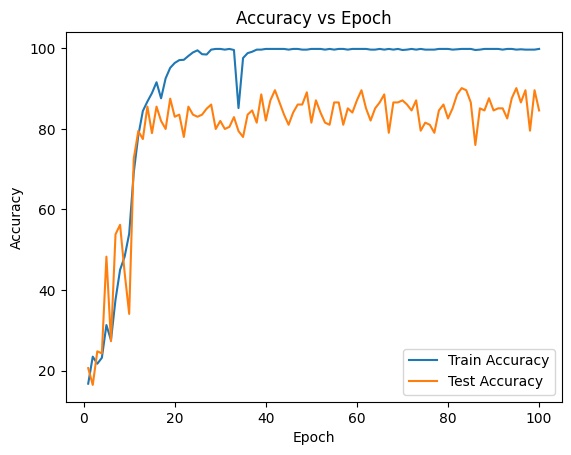

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs+1)

plt.plot(epochs_range, CNNtrainAccList, label='Train Accuracy')
plt.plot(epochs_range, CNNtestAccList, label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

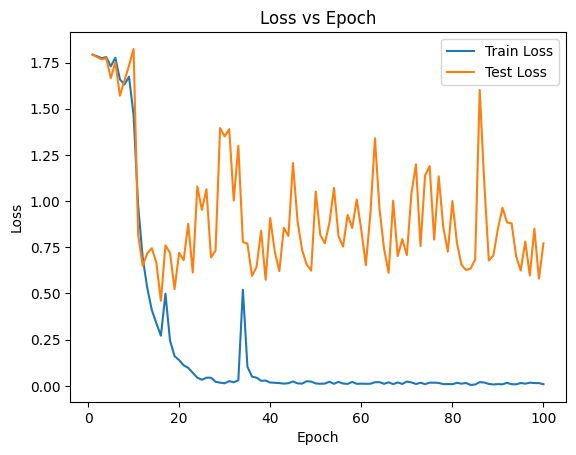

In [ ]:
plt.plot(epochs_range, CNNtrainLossList, label='Train Loss')
plt.plot(epochs_range, CNNtestLossList, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

## NN Train

In [ ]:
#https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb
# see point 7.4 "Training and testing model_2 using our training and test functions"
from timeit import default_timer as timer
from tqdm.auto import tqdm # for progress bar
# Set seed start timer
train_time_start_on_gpu = timer()

# Set epoch number
epochs = 100

trainAccList = []
testAccList = []
trainLossList = []
testLossList = []

# Create train n test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  ### Training
  acc, loss = training_step(model = model,
                data_loader = train_dataloader,
                loss_fn = loss_fn,
                optimizer = optimizer,
                accuracy_fn = accuracy_fn,
                device = device)
  trainAccList.append(acc)
  trainLossList.append(loss.cpu().detach().numpy())

  ### Testing
  acc, loss = testing_step(model = model,
               data_loader = test_dataloader,
               loss_fn = loss_fn,
               accuracy_fn = accuracy_fn,
               device = device)

  testAccList.append(acc)
  testLossList.append(loss.cpu().detach().numpy())
# Calc train time
train_time_end_on_gpu = timer()
total_train_time_model = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=str(next(model.parameters()).device)) #next to get value of param, device to get where the value is located(gpu)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 1.79180 | Train acc: 14.08%

Test loss : 1.79245 | Test acc: 14.49%

Epoch: 1
-----
Train loss: 1.76814 | Train acc: 23.12%

Test loss : 1.77356 | Test acc: 23.77%

Epoch: 2
-----
Train loss: 1.75788 | Train acc: 23.94%

Test loss : 1.74179 | Test acc: 26.18%

Epoch: 3
-----
Train loss: 1.72255 | Train acc: 26.18%

Test loss : 1.80523 | Test acc: 17.09%

Epoch: 4
-----
Train loss: 1.70414 | Train acc: 28.43%

Test loss : 1.72859 | Test acc: 22.73%

Epoch: 5
-----
Train loss: 1.68493 | Train acc: 31.46%

Test loss : 1.71300 | Test acc: 30.87%

Epoch: 6
-----
Train loss: 1.66472 | Train acc: 31.54%

Test loss : 1.73008 | Test acc: 34.00%

Epoch: 7
-----
Train loss: 1.64375 | Train acc: 37.22%

Test loss : 1.73838 | Test acc: 19.60%

Epoch: 8
-----
Train loss: 1.63465 | Train acc: 39.89%

Test loss : 1.88102 | Test acc: 28.27%

Epoch: 9
-----
Train loss: 1.65833 | Train acc: 36.81%

Test loss : 1.71512 | Test acc: 27.32%

Epoch: 10
-----
Train loss: 1.57186 | Tr

### Graph NN

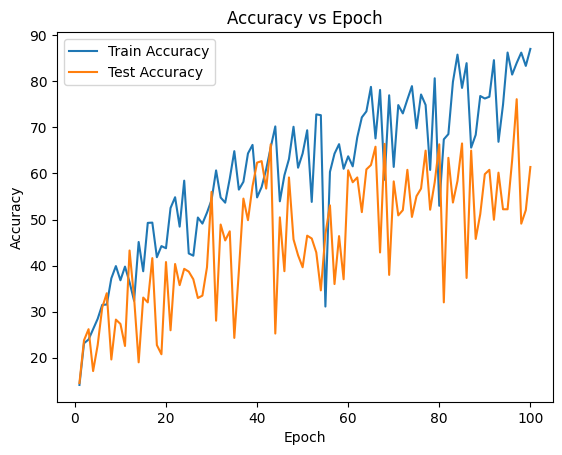

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs+1)

plt.plot(epochs_range, trainAccList, label='Train Accuracy')
plt.plot(epochs_range, testAccList, label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

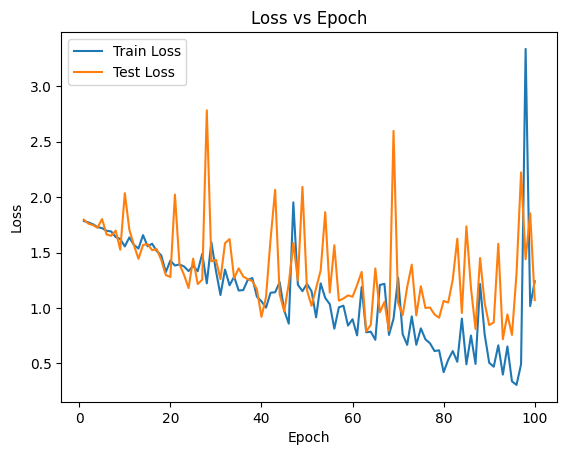

In [ ]:
plt.plot(epochs_range, trainLossList, label='Train Loss')
plt.plot(epochs_range, testLossList, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

2
tensor(2)


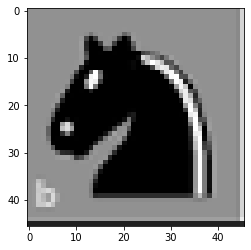

In [ ]:
def evalModel(model: torch.nn.Module,
                 img : torch.Tensor,
                 device: torch.device = device):
  model.eval()
  with torch.inference_mode():
    y_pred = model(img)
    label = torch.argmax(y_pred)
    print(torch.argmax(y_pred))

img,label = dataset.__getitem__(260)
print(label)
evalModel(model=model_2, img=img.unsqueeze(0).to(device), device=device)
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(convNet.parameters(), lr=0.001, momentum=0.9)

In [ ]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model = convNet, loss_fn = loss_fn, optimizer = optimizer)
    test_loop(test_dataloader, model = convNet, loss_fn = loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.801319  [   64/  554]
loss: 1.796838  [  384/  554]
Test Error: 
 Accuracy: 17.3%, Avg loss: 1.788057 

Epoch 2
-------------------------------
loss: 1.820753  [   64/  554]
loss: 1.810939  [  384/  554]
Test Error: 
 Accuracy: 17.3%, Avg loss: 1.807289 

Epoch 3
-------------------------------
loss: 1.798274  [   64/  554]
loss: 1.816135  [  384/  554]
Test Error: 
 Accuracy: 17.3%, Avg loss: 1.809127 

Epoch 4
-------------------------------
loss: 1.805432  [   64/  554]
loss: 1.781526  [  384/  554]
Test Error: 
 Accuracy: 17.3%, Avg loss: 1.804094 

Epoch 5
-------------------------------
loss: 1.798633  [   64/  554]
loss: 1.804222  [  384/  554]
Test Error: 
 Accuracy: 17.3%, Avg loss: 1.801461 

Epoch 6
-------------------------------
loss: 1.787528  [   64/  554]
loss: 1.800062  [  384/  554]
Test Error: 
 Accuracy: 17.3%, Avg loss: 1.808581 

Epoch 7
-------------------------------
loss: 1.782700  [   64/  554]
loss: 1.785605  [ 

KeyboardInterrupt: ignored

# Graph for 3

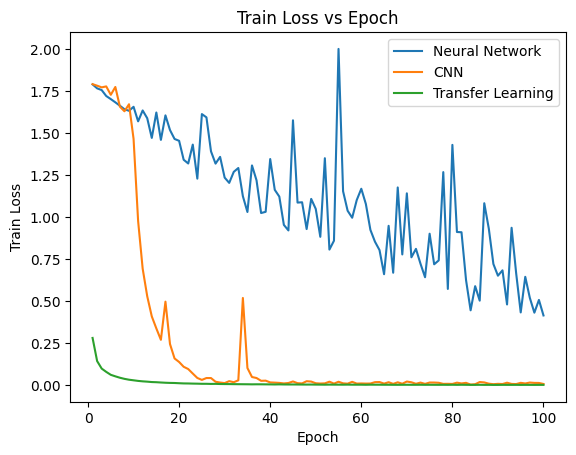

In [ ]:
plt.plot(epochs_range, trainLossList, label='Neural Network')
plt.plot(epochs_range, CNNtrainLossList, label='CNN')
plt.plot(epochs_range, history.history['loss'], label='Transfer Learning')

plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epoch')
plt.legend()
plt.show()

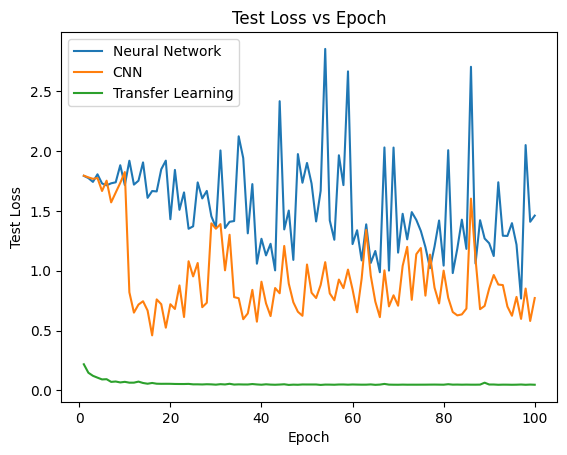

In [ ]:
plt.plot(epochs_range, testLossList, label='Neural Network')
plt.plot(epochs_range, CNNtestLossList, label='CNN')
plt.plot(epochs_range, history.history['val_loss'], label='Transfer Learning')

plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss vs Epoch')
plt.legend()
plt.show()

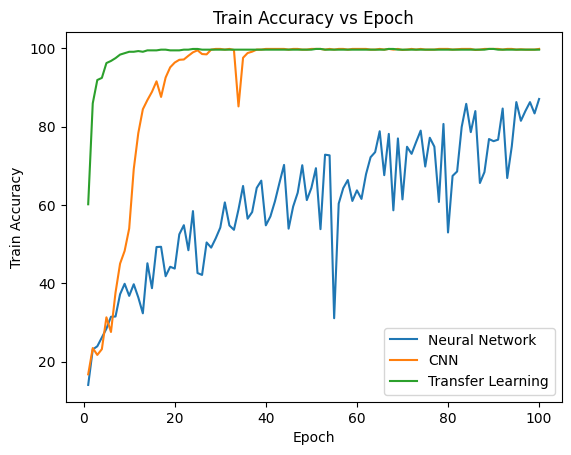

In [ ]:
plt.plot(epochs_range, trainAccList, label='Neural Network')
plt.plot(epochs_range, CNNtrainAccList, label='CNN')
plt.plot(epochs_range, acc_list, label='Transfer Learning')

plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()
plt.show()

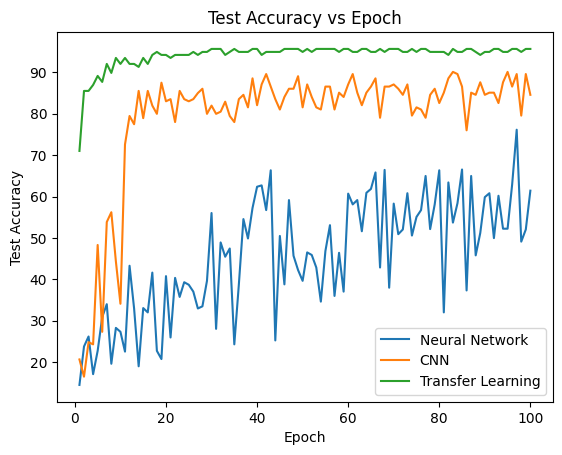

In [ ]:
plt.plot(epochs_range, testAccList, label='Neural Network')
plt.plot(epochs_range, CNNtestAccList, label='CNN')
plt.plot(epochs_range, val_acc_list, label='Transfer Learning')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()
plt.show()